In [1]:
import os
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
training_images_list = os.listdir('C:/Users/jayma/Downloads/flickr10k_images/flickr10k_images/flickr10k_images')

In [3]:
sample_image_size = 20
training_images_list = training_images_list[:sample_image_size]

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import random

In [5]:
size = (256, 256)
num_channels = 3

In [6]:
train = np.array([None] * sample_image_size)
real_images = np.array([None] * sample_image_size)

In [7]:
j = 0
for i in training_images_list:
    real_images[j] = np.array(plt.imread('C:/Users/jayma/Downloads/flickr10k_images/flickr10k_images/flickr10k_images/'+ i))
    train[j] = np.array(plt.imread('C:/Users/jayma/Downloads/flickr10k_images/flickr10k_images/flickr10k_images/' + i))
    j += 1

In [8]:
j  = 0
for i in train:
    train[j] = cv2.resize(i, size)
    train[j] = train[j].reshape(1, size[0], size[1], num_channels)
    j += 1

In [9]:
train = np.vstack(train[:])

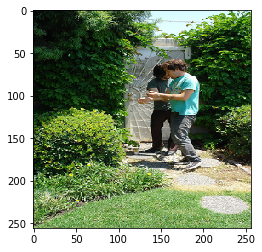

In [10]:
plt.imshow(np.squeeze(train[0]))
plt.show()

In [11]:
import pandas as pd

In [12]:
training_captions = pd.read_csv('C:/Users/jayma/Downloads/flickr10k_images/flickr10k_images/results.csv', delimiter='|')

In [13]:
def get_images_id(names):
    names = [int(x.split('_')[-1].split('.')[0]) for x in names]
    return names

In [14]:
training_captions.columns = ['image_name', 'comment_number', 'comment']

In [15]:
def images_map_caption(training_images_list, training_captions):
    caption = []
    for i in training_images_list:
        caption.append(training_captions[training_captions['image_name'] == i]['comment'].iat[0])
    return caption

In [16]:
captions = np.array(images_map_caption(training_images_list, training_captions))
print(captions.shape)

(20,)


In [17]:
import re

In [18]:
starting_tag = '<s>'
ending_tag = '<e>'

In [229]:
def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m
    j  = 0
    for i in captions:
        i = re.sub(' +',' ',i)
        i = starting_tag + ' ' + i + ' ' + ending_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(set(arr))
    vocab_size = len(arr)
    j = 0
    fwd_dict = {}
    rev_dict = {}
    j = 0
    for i in arr:
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence, fwd_dict, rev_dict

In [230]:
vocab_size, sentences, fwd_dict, rev_dict = get_vocab(captions)

In [231]:
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

In [232]:
#Spare row matrix has been compressed
m = len(sentences)
training_caption = [None] * m
i = 0
for sentence in sentences:
    cap_array = None
    for word in sentence:
        row = [0]
        col = [fwd_dict[word]]
        data = [1]
        if cap_array is None:
            cap_array = csr_matrix((data, (row, col)), shape=(1, vocab_size))
        else:
            cap_array = vstack((cap_array, csr_matrix((data, (row, col)), shape=(1, vocab_size))))
    training_caption[i] = cap_array
    i += 1

In [233]:
training_caption[0].shape

(19, 168)

#### Training Model

In [234]:
def create_weights(shape, suffix):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.7), name='W_' + suffix)

def create_biases(size, suffix):
    return tf.Variable(tf.zeros([size]), name='b_' + suffix)

In [236]:
 #Defining Convolution layer and ReLU
def conv_layer(inp, kernel_shape, num_channels, num_kernels, suffix):
    filter_shape = [kernel_shape[0], kernel_shape[1], num_channels, num_kernels]
    weights = create_weights(shape=filter_shape, suffix=suffix)
    biases = create_biases(num_kernels, suffix=suffix)
    layer = tf.nn.conv2d(input=inp, filter=weights, padding='SAME', strides=[1, 1, 1, 1], name='conv_' + suffix)
    layer += biases
    layer = tf.nn.relu6(layer, name='relu_' + suffix)
    return layer

In [237]:
#Defining flattening layer
def flatten_layer(layer, suffix):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features], name='flat_' + suffix )
    return layer

In [238]:
#Defining dense layer
def dense_layer(inp, num_inputs, num_outputs, suffix, use_relu=True):
    weights = create_weights([num_inputs, num_outputs], suffix)
    biases = create_biases(num_outputs, suffix)
    layer = tf.matmul(inp, weights) + biases
    layer = tf.nn.relu(layer)
    return layer

In [239]:
#Defining Recurrent Neural Network
def rnn_cell(Win ,Wout, Wfwd, b, hprev, inp):
    h = tf.tanh(tf.add(tf.add(tf.matmul(inp, Win), tf.matmul(hprev, Wfwd)), b))
    out = tf.matmul(h, Wo)
    return h, out

In [240]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [241]:
tf.device("/device:GPU:0")

In [242]:
learning_rate = 0.001
training_iters = 500
display_step = 100
max_sent_limit = 50
num_tests = 12
bridge_size = 1024
keep_prob = 0.3

In [243]:
x_caption = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')
x_inp = tf.placeholder(tf.float32, shape=[1, size[0],size[1],num_channels], name='x_image')
y = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')

In [244]:
Wconv = tf.Variable(tf.truncated_normal([bridge_size, vocab_size], stddev=0.7))
bconv = tf.Variable(tf.zeros([1, vocab_size]))
Wi= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wf= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wo= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
b = tf.Variable(tf.zeros([1, vocab_size]))

In [245]:
layer_conv1 = conv_layer(inp=x_inp, kernel_shape=(3, 3), num_kernels=32, num_channels=3, suffix='1')
layer_conv2 = conv_layer(inp=layer_conv1, kernel_shape=(3, 3), num_kernels=32, num_channels=32, suffix='2')
maxpool1 = tf.nn.max_pool(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv3 = conv_layer(inp=maxpool1, kernel_shape=(3, 3), num_kernels=64, num_channels=32, suffix='3')
layer_conv4 = conv_layer(inp=layer_conv3, kernel_shape=(3, 3), num_kernels=64, num_channels=64, suffix='4')
maxpool2 = tf.nn.max_pool(layer_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv5 = conv_layer(inp=maxpool2, kernel_shape=(3, 3), num_kernels=128, num_channels=64, suffix='5')
layer_conv6 = conv_layer(inp=layer_conv5, kernel_shape=(3, 3), num_kernels=128, num_channels=128, suffix='6')
maxpool3 = tf.nn.max_pool(layer_conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv7 = conv_layer(inp=maxpool3, kernel_shape=(3, 3), num_kernels=256, num_channels=128, suffix='7')
layer_conv8 = conv_layer(inp=layer_conv7, kernel_shape=(3, 3), num_kernels=256, num_channels=256, suffix='8')

In [246]:
flat_layer = flatten_layer(layer_conv8, suffix='9')
dense_layer_1 = dense_layer(inp=flat_layer, num_inputs=262144 , num_outputs=bridge_size, suffix='10')

In [247]:
start_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[starting_tag]])), shape=(1, vocab_size)).A, tf.float32)
end_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[ending_tag]])), shape=(1, vocab_size)).A, tf.float32)

In [248]:
hook = tf.slice(x_caption, [0, 0], [1, vocab_size])
h = dense_layer_1
h, out = rnn_cell(Wi ,Wo, Wconv, bconv, h, hook)

In [249]:
def fn(prev, curr):
    h = prev[0]
    curr = tf.reshape(curr, [1, vocab_size])
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, curr)
    return h, out

In [250]:
_, output = tf.scan(fn, x_caption[1:], initializer=(h, out))

In [251]:
output = tf.squeeze(output, axis  = 1)

In [252]:
outputs = tf.concat([out, output], axis = 0)

In [253]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [254]:
pred = tf.nn.softmax(outputs)

In [255]:
# Evaluating the model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#### Predictive Model

In [256]:
out_tensor = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size = 0)

In [257]:
htest = dense_layer_1
htest, out_first = rnn_cell(Wi ,Wo, Wconv, bconv, htest, start_hook)
t = 0
out_ = tf.one_hot(tf.argmax(tf.nn.softmax(out_first), 1), depth=vocab_size)
out_tensor = out_tensor.write(t, out_)
t += 1

In [258]:
def condition(res, h, out_tensor, t):
    return tf.logical_and(tf.logical_not(tf.equal(tf.argmax(res, 1)[0], fwd_dict[ending_tag])), tf.less(t, max_sent_limit))

In [259]:
def action(res, h, out_tensor, t):
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, res)
    res = tf.one_hot(tf.argmax(tf.nn.softmax(out), 1), depth=vocab_size)
    out_tensor = out_tensor.write(t, res)
    return res, h, out_tensor, t + 1

In [260]:
_, __, final_outputs, T = tf.while_loop(condition, action, [out_, htest, out_tensor, t])

In [261]:
final_prediction = tf.squeeze(final_outputs.stack())

In [262]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

##### Implementation

Optimization is done
And it's time to check
(50, 168)
Predicted Caption: <s> details beer mug jacket lot other fence giant an other through climbing standing smiling front The look against blond lion sky van tie time Five cellphone mug dressed playing officer rollerskates coffee van their neighborhood out time and black their suburban obliverate men Germany people stair net , 
Orignal Caption: Two young guys with shaggy hair look at their hands while hanging out in the yard . 


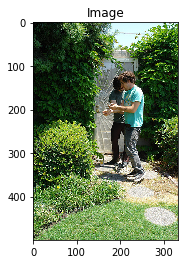

(50, 168)
Predicted Caption: window chair window sits details look black dress dress his sits the uniformly stairs dress <s> by garden details dark-skinned coffee smiling her hanging photo looks her cellphone reflective girl same back officer camera sits net hanging red garden suit . hat rail dark-skinned animal working officer cold back 
Orignal Caption: Five people walking with a multicolored sky in the background . 


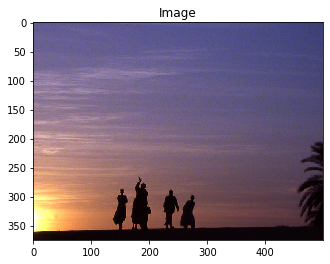

(50, 168)
Predicted Caption: <s> details beer mug jacket lot other fence giant an other through climbing standing smiling front The look against blond lion sky van tie time Five cellphone mug dressed playing officer rollerskates coffee van their neighborhood out time and black their suburban obliverate men Germany people stair net , 
Orignal Caption: Two young guys with shaggy hair look at their hands while hanging out in the yard . 


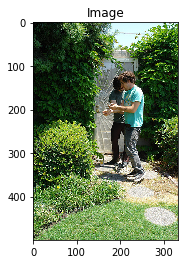

(50, 168)
Predicted Caption: <s> details beer mug jacket lot other fence giant an other through climbing standing smiling front The look against blond lion sky van tie time Five cellphone mug dressed playing officer rollerskates coffee van their neighborhood out time and black their suburban obliverate men Germany people stair net , 
Orignal Caption: Two young guys with shaggy hair look at their hands while hanging out in the yard . 


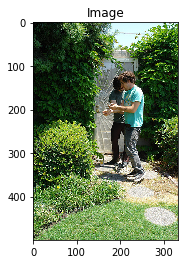

(50, 168)
Predicted Caption: window uniformly caucasian white black cellphone Young uniformly caucasian hair white climbing caucasian surrounded caucasian van jumping while Young shirts caucasian caucasian dark-skinned dress cellphone " grassy an red asian cap woman net details his rollerskates in . van near are look tan yard caucasian young hanging smiling lot 
Orignal Caption: Two men in Germany jumping over a rail at the same time without shirts . 


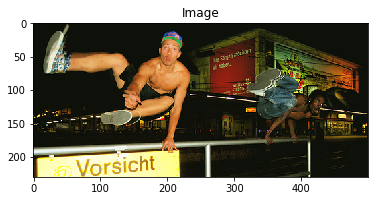

(50, 168)
Predicted Caption: hair uniformly caucasian fence " asian sits window people set smiling Germany stands stair " lion up at black a way parking cellphone fence slacks hats playing up caucasian her ground red up a up without jacket neighborhood in near playing factory asian operating Two a red glass rail 
Orignal Caption: Young blond man in a blue and yellow jacket smiling while standing in front of a net . 


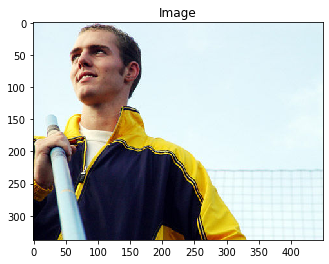

(50, 168)
Predicted Caption: window officer entry ground net uniformly officer near van hat hats poking dark-skinned Germany hard jacket operating backwards with near jacket Germany seem stairs hat Germany slacks surrounded suburban beer dog Two white animal jumping caucasian guitar garden the with The converse surrounded , reflective same talking jacket men 
Orignal Caption: Five men , uniformly dressed in white shirts , tie and black slacks converse at the back of an open van . 


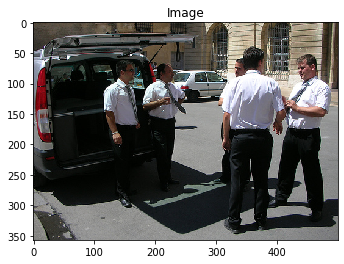

(50, 168)
Predicted Caption: window uniformly caucasian white black cellphone Young uniformly caucasian hair white climbing caucasian surrounded caucasian van jumping while Young shirts caucasian caucasian dark-skinned dress cellphone " grassy an red asian cap woman net details his rollerskates in . van near are look tan yard caucasian young hanging smiling lot 
Orignal Caption: Two men in Germany jumping over a rail at the same time without shirts . 


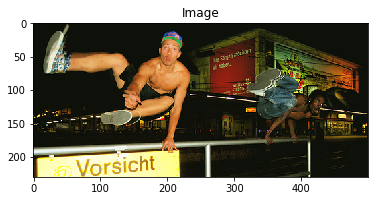

(50, 168)
Predicted Caption: window officer entry ground net uniformly officer near van hat hats poking dark-skinned Germany hard jacket operating backwards with near jacket Germany seem stairs hat Germany slacks surrounded suburban beer dog Two white animal jumping caucasian guitar garden the with The converse surrounded , reflective same talking jacket men 
Orignal Caption: Five men , uniformly dressed in white shirts , tie and black slacks converse at the back of an open van . 


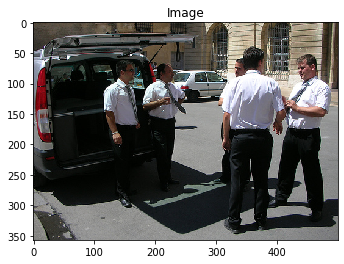

(50, 168)
Predicted Caption: <s> details beer mug jacket lot other fence giant an other through climbing standing smiling front The look against blond lion sky van tie time Five cellphone mug dressed playing officer rollerskates coffee van their neighborhood out time and black their suburban obliverate men Germany people stair net , 
Orignal Caption: Two young guys with shaggy hair look at their hands while hanging out in the yard . 


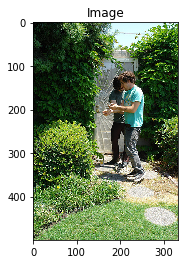

(50, 168)
Predicted Caption: window chair window sits details look black dress dress his sits the uniformly stairs dress <s> by garden details dark-skinned coffee smiling her hanging photo looks her cellphone reflective girl same back officer camera sits net hanging red garden suit . hat rail dark-skinned animal working officer cold back 
Orignal Caption: Five people walking with a multicolored sky in the background . 


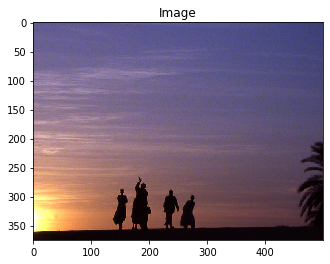

(50, 168)
Predicted Caption: window officer stair rail heavy time uniformly woman dark-skinned back dressed entry bicycle tie stands net him gray uniformly Five dark-haired Several way net chair yellow giant blue operating dressed Five giant cap with near at coffee black suburban giant up caucasian way giant asian shirts up window shaggy 
Orignal Caption: A caucasian man wearing a short-sleeved black shirt and a dark-skinned woman wearing a sleeveless dress are working at a conveyor . 


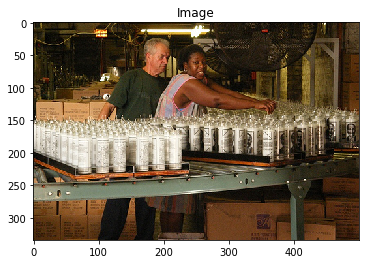

In [263]:
with tf.Session() as sess:
    sess.run(init)
    m = len(training_caption)
    for epoch in range(training_iters):
        total_cost = 0
        total_acc = 0
        for i in range(m):
            _, cst, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x_caption:training_caption[i][:-1].A, x_inp:train[i:i+1], y:training_caption[i][1:].A})
            total_cost += cst
            total_acc += acc
        if (epoch + 1) % display_step == 0:
            print('After ', (epoch + 1), 'iterations: Cost = ', total_cost / m, 'and Accuracy: ', total_acc * 100/ m , '%' )
    print('Optimization is done')
    print("And it's time to check")
    for tests in range(num_tests):
        image_num = random.randint(0, sample_image_size - 1)
        caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
        print(caption.shape)
        caption = np.argmax(caption[:-1], 1)
        capt = ''
        for i in caption:
            capt += rev_dict[i] + ' '
        print('Predicted Caption:', capt)
        orig_cap = np.argmax(training_caption[image_num:image_num + 1][0][1:-1].A, 1)
        orignalcaption = ''
        for i in orig_cap:
            orignalcaption += rev_dict[i] + ' '
        print('Orignal Caption:', orignalcaption)
        plt.imshow(real_images[image_num])
        plt.title('Image')
        plt.show()